In [336]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

In [337]:
# Generating random cluster centers
def getCenters(numDims): 
    centers = []
    centers.append(np.random.rand(numDims))
    centerPosChange = np.random.rand(numDims)
    centerPosChange = centerPosChange / np.linalg.norm(centerPosChange)
    newCenter = centers[0] + (centerPosChange * np.random.rand())
    while np.linalg.norm(newCenter-centers[0]) >= 1:
        centerPosChange = np.random.rand(numDims)
        centerPosChange = centerPosChange / np.linalg.norm(centerPosChange)
        newCenter = centers[0] + (centerPosChange * np.random.rand())
    centers.append(newCenter)
    centerPosChange = np.random.rand(numDims)
    centerPosChange = centerPosChange / np.linalg.norm(centerPosChange)
    newCenter = centers[np.random.randint(0,2)] + (centerPosChange) * np.random.rand()
    while np.linalg.norm(newCenter-centers[0]) >= 1 and np.linalg.norm(newCenter-centers[1]) >= 1:
        centerPosChange = np.random.rand(numDims)
        centerPosChange = centerPosChange / np.linalg.norm(centerPosChange)
        newCenter = centers[np.random.randint(0,2)] + (centerPosChange) * np.random.rand()
    centers.append(newCenter)
    return np.array(centers)

# Assign center classes 
def setCenterClasses(numCenters):
    centerClass = np.random.randint(0,2,numCenters)
    # Ensure at least one class present 
    if np.count_nonzero(centerClass) == 0:
        centerClass[np.random.randint(0,3)] = 1
    if np.count_nonzero(centerClass) == numCenters: 
        centerClass[np.random.randint(0,3)] = 0
    return centerClass

In [338]:
# Sample gaussian 
# Identity covariance 
def sampleGaussian(center):
    return np.random.normal(center, 1)

In [339]:
def MoG(numDims, numPoints):
    centers = getCenters(numDims)
    numCenters = centers.shape[0]
    centerClasses = setCenterClasses(numCenters)
    X = [] 
    y = []
    for i in range(0, numPoints):
        selectCenter = np.random.randint(0,numCenters)
        X.append(sampleGaussian(centers[selectCenter]))
        y.append(centerClasses[selectCenter])
    return np.array(X), np.array(y)

In [340]:
def splitData(X, y): 
    numTrain = int(X.shape[0] * 0.80)
    XTrain = X[:numTrain]
    yTrain = y[:numTrain]
    XTest = X[numTrain:]
    yTest = y[numTrain:]
    return XTrain, yTrain, XTest, yTest

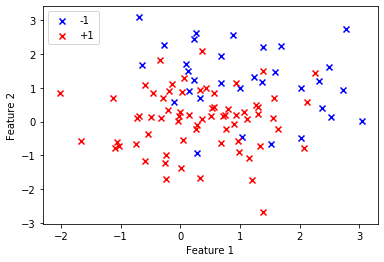

In [341]:
X, y = MoG(2,100)
colors = ['blue','red']
labels = ['-1','+1']
posIdx = np.argwhere(y==1)
negIdx = np.argwhere(y==0)
plt.scatter(X[negIdx,0],X[negIdx,1],\
    c=colors[0],label=labels[0],\
    marker='x')
plt.scatter(X[posIdx,0],X[posIdx,1],\
    c=colors[1],label=labels[1],\
    marker='x')
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

XTrain, yTrain, XTest, yTest = splitData(X,y)

In [342]:
# Sanity Check: Plot decision boundary (Linear Classifier)
def plotDecisionBinary(estimator,f1, f2, y,\
    f1Name, f2Name, title):
    colors = ['blue','red']
    labels = ['-1','+1']
    coefs = estimator.coef_[0]
    w0 = estimator.intercept_[0]
    w1 = coefs[0]
    w2 = coefs[1]
    intercept = - w0 / w2 
    slope = - w1 / w2 
    # Get line boundaries 
    lineXMin = np.amin(f1)
    lineXMax = np.amax(f1)
    lineX = np.linspace(lineXMin, lineXMax)
    lineY = slope * lineX + intercept
    # Plot points 
    plt.figure()
    for i in range(0,f1.shape[0]):
        plt.plot(f1[i], f2[i], "x", color=colors[y[i]])
    plt.plot(lineX, lineY, 'k')
    plt.xlim(lineXMin - 1, lineXMax + 1)
    # Set window y boundaries 
    lineYMin = np.amin(f2)
    lineYMax = np.amax(f2)
    plt.ylim(lineYMin - 1, lineYMax + 1)
    plt.xlabel(f1Name)
    plt.ylabel(f2Name)
    plt.suptitle(title)
    legendElements = [\
    Patch(facecolor=colors[0], edgecolor=colors[0],\
         label=labels[0]),\
    Patch(facecolor=colors[1], edgecolor=colors[1],\
         label=labels[1]),
    ]
    plt.legend(handles=legendElements)

In [343]:
# Sanity Check: Plot decision boundaries (kNeighbors Classifier)
def plotDecisionBoundary2Features(X,y, numNeighs, xLabel, yLabel, title):
    NNBasic = KNeighborsClassifier(n_neighbors=numNeighs)
    NNBasic.fit(X,y)

    # Define plot range 
    plotXMin, plotXMax, plotYMin, plotYMax =\
        X[:,0].min() - 1,\
        X[:,0].max() + 1,\
        X[:,1].min() - 1,\
        X[:,1].max() + 1

    # Define plot step-size
    step = 0.01
    plotXs, plotYs = np.meshgrid(np.arange(plotXMin, plotXMax, step),\
                                np.arange(plotYMin, plotYMax, step))

    # Transform back to original space 
    predictions = NNBasic.predict(np.c_[plotXs.ravel(), plotYs.ravel()])
    # Perform predictions in original 4D feature space
    predictions = predictions.reshape(plotXs.shape)

    # Define color maps for plot 
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    # Plot decision boundaries
    plt.figure()
    plt.pcolormesh(plotXs, plotYs, predictions, cmap=cmap_light)

    # Plot training points 
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap_bold,\
                edgecolor='k', s=20)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.suptitle(title)
    labels = ['-1', '+1']
    legendElements = [\
        Patch(facecolor='#FF0000', edgecolor='#FF0000',\
             label=labels[0]),\
        Patch(facecolor='#0000FF', edgecolor='#0000FF',\
             label=labels[1]),\
    ]
    plt.legend(handles=legendElements)

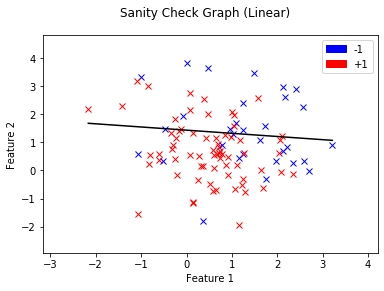

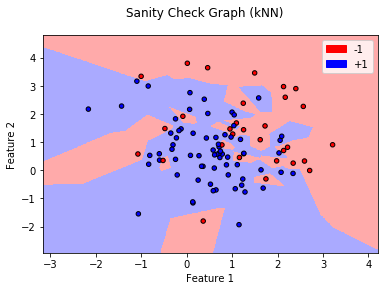

In [344]:
X, y = MoG(2,100)
linClf = SGDClassifier()
linClf.fit(X, y)
plotDecisionBinary(linClf, X[:,0], X[:,1], y,\
    "Feature 1", "Feature 2", "Sanity Check Graph (Linear)")
plotDecisionBoundary2Features(X,y, 1, "Feature 1", "Feature 2", "Sanity Check Graph (kNN)")

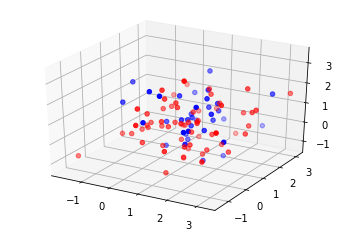

In [345]:
# Another sanity check: MoG in 3D
X, y = MoG(3,100)
colors = ['blue','red']
labels = ['-1','+1']
posIdx = np.argwhere(y==1)
negIdx = np.argwhere(y==0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
posIdx = np.argwhere(y==1)
negIdx = np.argwhere(y==0)
ax.scatter(X[negIdx,0],X[negIdx,1],X[negIdx,2],color=colors[0])
ax.scatter(X[posIdx,0],X[posIdx,1],X[posIdx,2],color=colors[1])

In [346]:
dims = [2,10,100,1000]
ks = np.array([1, 50, 100, 150, 200, 250, 300, 350, 400])
for dim in dims: 
    X, y = MoG(dim,1000)
    XTrain, yTrain, XTest, yTest = splitData(X,y)
    linClf = SGDClassifier()
    kNClfs = []
    for k in ks: 
        kNClfs.append(KNeighborsClassifier(n_neighbors=k))
    numToAvg = 5 
    linScoreSum = 0 
    linTrainScoreSum = 0
    kNScoreSums = np.zeros(ks.shape[0])
    kNTrainScoreSums = np.zeros(ks.shape[0])
    for i in range(0,numToAvg):
        linClf.fit(XTrain, yTrain)
        linScoreSum += linClf.score(XTest, yTest)
        linTrainScoreSum += linClf.score(XTrain, yTrain)
        for i in range(0, ks.shape[0]):
            kNClfs[i].fit(XTrain, yTrain)
            kNScoreSums[i] += kNClfs[i].score(XTest, yTest)
            kNTrainScoreSums[i] += kNClfs[i].score(XTrain, yTrain)
    linScore = linScoreSum / numToAvg
    linTrainScore = linTrainScoreSum / numToAvg
    kNScores = kNScoreSums / numToAvg
    knTrainScores = kNTrainScoreSums / numToAvg
    print("Dimension: " + str(dim))
    print("Linear Accuracy (Train): " + str(linTrainScore))
    print("Linear Accuracy (Test): " + str(linScore))
    for i in range(0, ks.shape[0]):
        print("kNClassifier Accuracy (Train, k = " + str(ks[i]) + "): " + str(knTrainScores[i]))
        print("kNClassifier Accuracy (Test, k = " + str(ks[i]) + "): " + str(kNScores[i]))

Dimension: 2
Linear Accuracy (Train): 0.64825
Linear Accuracy (Test): 0.632
kNClassifier Accuracy (Train, k = 1): 1.0
kNClassifier Accuracy (Test, k = 1): 0.545
kNClassifier Accuracy (Train, k = 50): 0.685
kNClassifier Accuracy (Test, k = 50): 0.635
kNClassifier Accuracy (Train, k = 100): 0.6575
kNClassifier Accuracy (Test, k = 100): 0.63
kNClassifier Accuracy (Train, k = 150): 0.65125
kNClassifier Accuracy (Test, k = 150): 0.645
kNClassifier Accuracy (Train, k = 200): 0.66
kNClassifier Accuracy (Test, k = 200): 0.66
kNClassifier Accuracy (Train, k = 250): 0.66125
kNClassifier Accuracy (Test, k = 250): 0.66
kNClassifier Accuracy (Train, k = 300): 0.66125
kNClassifier Accuracy (Test, k = 300): 0.66
kNClassifier Accuracy (Train, k = 350): 0.66125
kNClassifier Accuracy (Test, k = 350): 0.66
kNClassifier Accuracy (Train, k = 400): 0.66125
kNClassifier Accuracy (Test, k = 400): 0.66
Dimension: 10
Linear Accuracy (Train): 0.6105
Linear Accuracy (Test): 0.588
kNClassifier Accuracy (Train, k =

In [347]:
dims = [2,10,100,1000]
X, y = MoG(500,1000)
XTrain, yTrain, XTest, yTest = splitData(X,y)
linClf = SGDClassifier()
linClf.fit(XTrain, yTrain)
print(linClf.score(XTrain, yTrain))

0.9925
